# 指数投资

长期定投指数，赚取市场平均beta价值。
配合一定的自动策略赚取超额收益：
* 定期或根据PE进行比例调整的动态再平衡: 自动实现低买高卖的大波段
* 使用等价值定投方案进行定投: 自动实现低买高卖大波段 － 将定投资金考虑在内
* 根据估值分析进行定期指数轮动再平衡: 将单独指数标的扩展为多市场标的池，赚取多市场再平衡的超额收益
* 利用网格交易等方法获取短中期波段收益: 可配合定投方案实现超额收益，赚取小波段收益
* 为其他方案提供稳定的做空工具: 可以充分提高这部分资金的利用率

## 测试1: 单一标的简单买入持有收益
买入并持有单一ETF标的，例如沪深300，买入并持有。

In [1]:
%matplotlib inline
from opentrader.core.crawler import *
from datetime import datetime
from opentrader.jupyter.lib.plot import *
from opentrader.ceres.account import Account
from opentrader.ceres.trade import *
from datetime import datetime
from opentrader.common.utils import d2dt


In [2]:
def buy_and_hold_research(symbol):
    #symbol = "QQQ"#"SH000300"
    cr = CNCrawler()
    kday_data = cr.get_k_day(symbol, "1990-01-01 00:00:00")
    print("Start date: %s, End date: %s, Total dates: %d" % (kday_data[0]['date'], kday_data[-1]['date'], len(kday_data)))
    draw_line(symbol, [q['date'] for q in kday_data], [{"value":[q['close'] for q in kday_data]}])
    
    # 买入并持有策略
    account = Account(1000000.0, d2dt(kday_data[0]['date']))
    number = int(account.cash / kday_data[0]['open'])
    account.trade(Trade(symbol, DIR_LONG, number, kday_data[0]['open'], d2dt(kday_data[0]['date'])))
    for kday in kday_data:
        account.update_quotes({symbol:kday['close']}, d2dt(kday['date']))
    draw_line('%s: Simple buy and hold' % symbol, [q[0] for q in account.history_net_value], [{"value":[q[1] for q in account.history_net_value]}])
    print("Average annual return rate: %f" % account.avr_annual_return_rate())
    dropdown = account.maximum_dropdown()
    print("Maximum drop down percent: %f, from %s to %s" % (dropdown[0], dropdown[1].date(), dropdown[2].date()))

    # 简单动态再平衡策略：始终维持半仓，每年第一个交易日再平衡
    account = Account(1000000.0, d2dt(kday_data[0]['date']))
    number = int(account.cash * 0.5 / kday_data[0]['open'])
    account.trade(Trade(symbol, DIR_LONG, number, kday_data[0]['open'], d2dt(kday_data[0]['date'])))
    current_year = kday_data[0]['date'].year
    for kday in kday_data:
        account.update_quotes({symbol:kday['close']}, d2dt(kday['date']))
        if kday['date'].year > current_year:
            # first trade day of a year
            account.rebalance({symbol:0.5, 'cash':0.5}, kday['date'])
        current_year = kday['date'].year

    draw_line('%s: Simple rebalance' % symbol, [q[0] for q in account.history_net_value], [{"value":[q[1] for q in account.history_net_value]}])
    print("Average annual return rate: %f" % account.avr_annual_return_rate())
    dropdown = account.maximum_dropdown()
    print("Maximum drop down percent: %f, from %s to %s" % (dropdown[0], dropdown[1].date(), dropdown[2].date()))
    

Start date: 2005-01-04, End date: 2016-07-26, Total dates: 2809


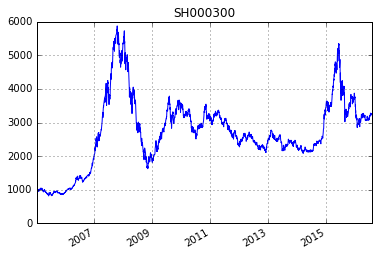

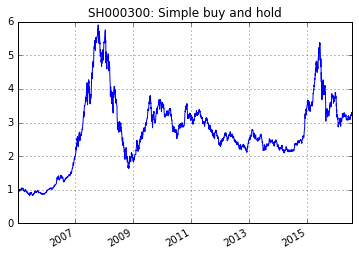

Average annual return rate: 0.107216
Maximum drop down percent: 0.723007, from 2007-10-17 to 2008-11-05


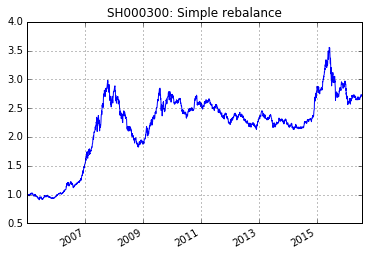

Average annual return rate: 0.090184
Maximum drop down percent: 0.388114, from 2007-10-17 to 2008-11-05


In [3]:
buy_and_hold_research("SH000300")
#buy_and_hold_research("SP500")
#buy_and_hold_research("QQQ")
#buy_and_hold_research("HKHSI")

## 测试2: 网格逆向买卖赚取小波段收益

Start date: 2016-01-04, End date: 2016-07-26, Total dates: 138
1000000.0
1007364.2743800498
1014655.6351523763
1021874.8042338877
1029022.4963938
1036099.4193244062
1043106.273711145
1050043.7533019756
1056912.5449760652
1063713.3288117975
1056844.537137708
1049907.0575468773
1042900.2031601385
1049837.682750969
1042830.8283642301
1035753.9054336239
1042760.7598203628
1049698.2394111934
1056567.031085283
1063367.8149210154
1070101.2642633247
1076768.0457903636
1083368.819579511
1076702.038052472
1069968.5887101628
1063167.8048744304
1069901.2542167397
1076568.0357437786
1083168.809532926
1089704.2291261412
1083103.4553369938
1076436.673809955
1083037.4475991023
1089572.8671923175
1096043.5796608473
1102450.2256692927
1095979.513200763
1102386.1592092083
1108729.3730789563
1115009.782850984
1121228.010348041
1127384.6712362163
1121166.4437391593
1114886.0339671315
1108542.8200973836
1102136.1740889382
1108479.387958686
1114759.7977307138
1120978.025227771
1127134.6861159462
1120916.4586

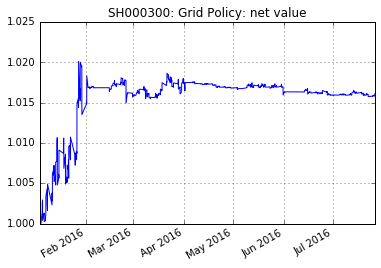

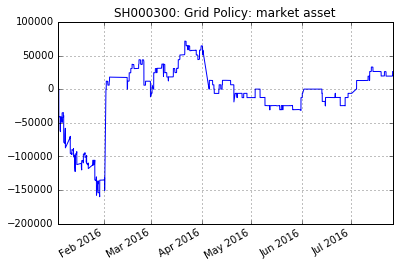

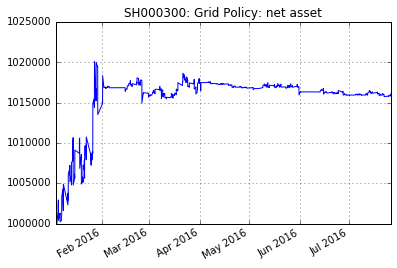

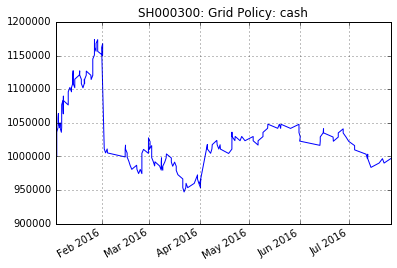

Average annual return rate: 0.028925
Maximum drop down percent: 0.006476, from 2016-01-27 to 2016-01-29


In [8]:
# 简单百分比网格策略：1000为基准，上涨、下跌2%为一档，向上触及则卖出，向下触及则买入
class Grid(object):
    def __init__(self, base, width, init):
        self._grid = []
        for i in range(200):
            self._grid.append(base * ((1-width)**(200-i)))
        for i in range(200):
            self._grid.append(base * ((1+width)**i))
        
        # point "i" means the current value is >= self._grid[i] and < self._grid[i+1]
        self._point = -1
        # find the location of the init value
        for (i, each) in enumerate(self._grid):
            if init < each:
                self._point = i-1
                break
        assert(self._point != -1)
    
    # go to next value, call the check_cb when passing any grid line
    # check_cb(<direction>, <touch_value>)
    # <direction> is 1 or -1 meaning up or down
    # <pass_value> is the touched line
    def checkpoint(self, value, check_cb=None, options={}):
        def default_cb(dir, pass_val):
            print(dir, pass_val)
        if not check_cb:
            check_cb = default_cb
        step = 0
        lower = self._grid[self._point-1]
        higher = self._grid[self._point+1]
        if value > lower and value < higher:
            pass
        elif value <= lower:
            step = 1
            while (value <= self._grid[self._point-step]):
                check_cb(-1, self._grid[self._point-step], options)
                step += 1
            self._point = self._point-step+1
        elif value >= higher:
            step = 1
            while (value >= self._grid[self._point+step]):
                check_cb(1, self._grid[self._point+step], options)
                step += 1
            self._point = self._point+step-1
        return self._point

def grid_policy(symbol):
    cr = CNCrawler()
    kday_data = cr.get_k_day(symbol, "2016-01-01 00:00:00")
    print("Start date: %s, End date: %s, Total dates: %d" % (kday_data[0]['date'], kday_data[-1]['date'], len(kday_data)))
    
    account = Account(1000000.0, d2dt(kday_data[0]['date']))
    def touch_grid_cb(direction, pass_val, options):
        print(account.cash)
        account.trade(Trade(symbol, 1 * direction, 2, pass_val, options['time']))
    
    grid = Grid(1000.0, 0.01, kday_data[0]['open'])
    current_month = kday_data[0]['date'].month
    for (i, kday) in enumerate(kday_data):
        if kday['open'] >= kday['close']:
            account.update_quotes({symbol:kday['open']}, d2dt(kday['date'], 9))
            grid.checkpoint(kday['open'], touch_grid_cb, {'time':d2dt(kday['date'], 9)})
            account.update_quotes({symbol:kday['high']}, d2dt(kday['date'], 10))
            grid.checkpoint(kday['high'], touch_grid_cb, {'time':d2dt(kday['date'], 10)})
            account.update_quotes({symbol:kday['low']}, d2dt(kday['date'], 14))
            grid.checkpoint(kday['low'], touch_grid_cb, {'time':d2dt(kday['date'], 14)})
            account.update_quotes({symbol:kday['close']}, d2dt(kday['date'], 15))
            grid.checkpoint(kday['close'], touch_grid_cb, {'time':d2dt(kday['date'], 15)})
        else:
            account.update_quotes({symbol:kday['open']}, d2dt(kday['date'], 9))
            grid.checkpoint(kday['open'], touch_grid_cb, {'time':d2dt(kday['date'], 9)})
            account.update_quotes({symbol:kday['low']}, d2dt(kday['date'], 10))
            grid.checkpoint(kday['low'], touch_grid_cb, {'time':d2dt(kday['date'], 10)})
            account.update_quotes({symbol:kday['high']}, d2dt(kday['date'], 14))
            grid.checkpoint(kday['high'], touch_grid_cb, {'time':d2dt(kday['date'], 14)})
            account.update_quotes({symbol:kday['close']}, d2dt(kday['date'], 15))
            grid.checkpoint(kday['close'], touch_grid_cb, {'time':d2dt(kday['date'], 15)})
        
        if kday['date'].month > current_month:
            # first trade day of a month
            account.rebalance({'cash':1.0}, d2dt(kday['date']))
        current_month = kday['date'].month
    
    draw_line('%s: Grid Policy: net value' % symbol, [q[0] for q in account.history_net_value], [{"value":[q[1] for q in account.history_net_value]}])
    draw_line('%s: Grid Policy: market asset' % symbol, [q[0] for q in account.history_market_asset], [{"value":[q[1] for q in account.history_market_asset]}])
    draw_line('%s: Grid Policy: net asset' % symbol, [q[0] for q in account.history_net_asset], [{"value":[q[1] for q in account.history_net_asset]}])
    draw_line('%s: Grid Policy: cash' % symbol, [q[0] for q in account.history_cash], [{"value":[q[1] for q in account.history_cash]}])

    print("Average annual return rate: %f" % account.avr_annual_return_rate())
    dropdown = account.maximum_dropdown()
    print("Maximum drop down percent: %f, from %s to %s" % (dropdown[0], dropdown[1].date(), dropdown[2].date()))
    

#grid_policy("NASDAQ")
grid_policy("SH000300")